# Case 1: Loans
## Introductory Data Viewing

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline


df = pd.read_csv("/Users/jakebodea/Projects/Full Stack Case Studies/loans_full_schema.csv")
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


From the first look, it seems that the data set is very messy, though somewhat thoroughly put together. Below will be some visualizations to see any potential trends. 

## Data Visualizations 

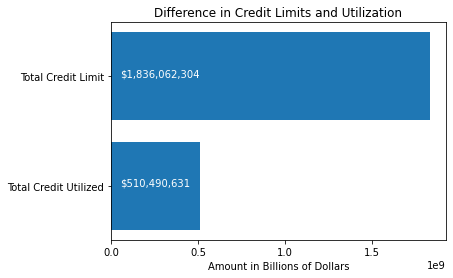

In [2]:
width = [sum(df['total_credit_utilized']), sum(df['total_credit_limit'])]
label = ["Total Credit Utilized","Total Credit Limit"]

plt.barh(label, width)
plt.xticks(np.arange(0, 2e09, 5e08))
plt.xlabel('Amount in Billions of Dollars')
plt.title('Difference in Credit Limits and Utilization')
plt.annotate("${:,}".format(width[0]), (0.05e09, 0), color='w')
plt.annotate("${:,}".format(width[1]), (0.05e09, 1), color='w')
plt.show()

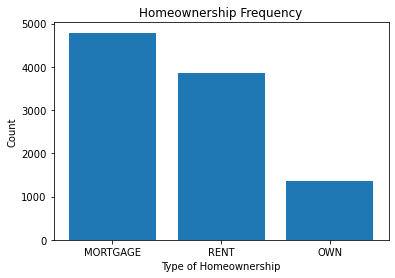

In [3]:
frequency = {}

for owner in df['homeownership']:
    if owner in frequency:
        frequency[owner] += 1
    else:
        frequency[owner] = 1
        
plt.bar(frequency.keys(), frequency.values())
plt.ylabel('Count')
plt.xlabel('Type of Homeownership')
plt.title('Homeownership Frequency')
plt.show()

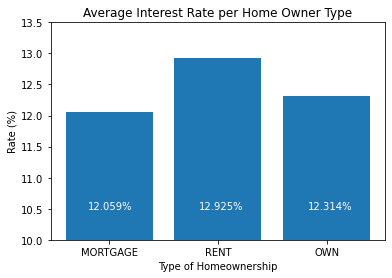

In [4]:
owners = frequency.keys()

avg_owner_interest = []
for owner in owners:
    avg_owner_interest.append(np.mean(df[df['homeownership'] == owner]['interest_rate']))

plt.bar(owners, avg_owner_interest)
plt.xlabel('Type of Homeownership')
plt.ylabel('Rate (%)')
plt.title('Average Interest Rate per Home Owner Type')
plt.ylim(10,13.5)

plt.annotate(str(round(avg_owner_interest[0], 3)) + '%', (-.2,10.5), color='w')
plt.annotate(str(round(avg_owner_interest[1], 3)) + '%', (0.825, 10.5), color='w')
plt.annotate(str(round(avg_owner_interest[2], 3)) + '%', (1.825,10.5), color='w')

plt.show()

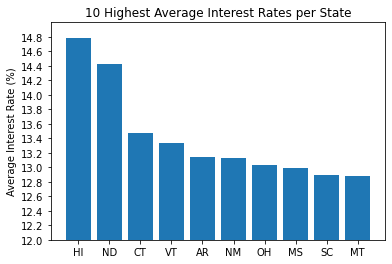

In [5]:
from heapq import nlargest

state_interest = {} # dict of {state: avg interest rate}
for state in df['state']:
    if state in state_interest:
        pass
    else:
        state_interest[state] = np.mean(df[df['state'] == state]['interest_rate'])

state_interest = {key: value for key, value in sorted(state_interest.items())} # sorted alphabetically if desired later

top_10_states = nlargest(10, state_interest, key = state_interest.get) # list of 10 largest states' interest
top_10 = {}
for state in top_10_states:
    top_10[state] = state_interest[state]
    
plt.bar(top_10.keys(), top_10.values())
plt.title('10 Highest Average Interest Rates per State')
plt.ylabel('Average Interest Rate (%)')
plt.yticks(np.arange(12, 15, 0.2))
plt.ylim(12,15)
plt.show()

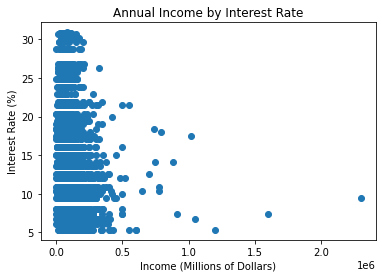

In [6]:
plt.scatter(df['annual_income'], df['interest_rate'])
plt.title('Annual Income by Interest Rate')
plt.xlabel('Income (Millions of Dollars)')
plt.ylabel('Interest Rate (%)')

plt.show()

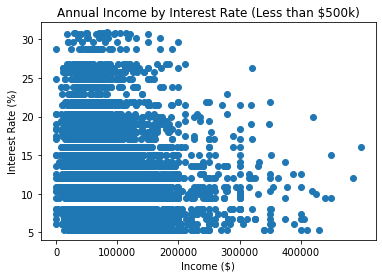

In [7]:
plt.scatter(df[df['annual_income'] < 500000]['annual_income'], df[df['annual_income'] < 500000]['interest_rate'])
plt.title('Annual Income by Interest Rate (Less than $500k)')
plt.xticks(np.arange(0,5e05, 1e05))
plt.xlabel('Income ($)')
plt.ylabel('Interest Rate (%)')

plt.show()

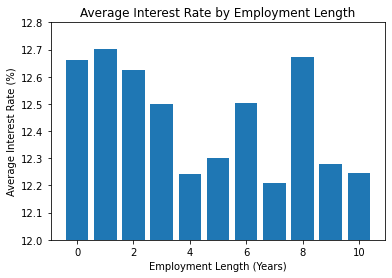

In [8]:
emp_interest = {}
for length in df['emp_length']:
    if length in emp_interest:
        pass
    else:
        emp_interest[length] = np.mean(df[df['emp_length'] == length]['interest_rate'])

plt.bar(emp_interest.keys(), emp_interest.values())
plt.title('Average Interest Rate by Employment Length')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Average Interest Rate (%)')
plt.ylim(12,12.8)

plt.show()

## Algorithms 

Since we are looking to predict a value `interest_rate`, we will be using two regression algorithms: Multiple Linear Regression and KNN. 

### Data Prep

In [9]:
# drop cols we will not use in analysis 

reg_df = df.drop(df.columns.difference(['emp_length', 'homeownership', 
                                        'annual_income', 'interest_rate', 'state']), axis=1)
reg_df.head()

,emp_length,state,homeownership,annual_income,interest_rate
0,3.0,NJ,MORTGAGE,90000.0,14.07
1,10.0,HI,RENT,40000.0,12.61
2,3.0,WI,RENT,40000.0,17.09
3,1.0,PA,RENT,30000.0,6.72
4,10.0,CA,RENT,35000.0,14.07


In [10]:
# makes tidy data
reg_df = pd.get_dummies(reg_df)
reg_df.dropna(inplace=True)

reg_df.head()

,emp_length,annual_income,interest_rate,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,homeownership_MORTGAGE,homeownership_OWN,homeownership_RENT
0,3.0,90000.0,14.07,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,10.0,40000.0,12.61,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3.0,40000.0,17.09,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1.0,30000.0,6.72,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,10.0,35000.0,14.07,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
x = reg_df.drop('interest_rate', axis=1)
y = reg_df['interest_rate']

from sklearn import preprocessing
names = x.columns
d = preprocessing.normalize(x, axis=1)
scaled_x = pd.DataFrame(d, columns=names)

In [12]:
from sklearn.model_selection import train_test_split

# creates some test data similar to original data to train our models 
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size = 0.2, random_state = 42)

### Multiple Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

LR.fit(x_train,y_train)

y_pred_LR =  LR.predict(x_test)


In [14]:
pred_LR = x_test.copy()
pred_LR['pred_interest_rate'] = y_pred_LR
pred_LR.head()

,emp_length,annual_income,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,homeownership_MORTGAGE,homeownership_OWN,homeownership_RENT,pred_interest_rate
4004,0.000102,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000010,0.00000,0.000000,11.915752
6412,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000018,12.841014
8177,0.000260,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000026,0.00000,0.000000,12.110246
7612,0.000080,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000008,0.00000,0.000000,11.956057
8911,0.000099,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00001,0.000000,12.162496


In [15]:
imp = LR.coef_

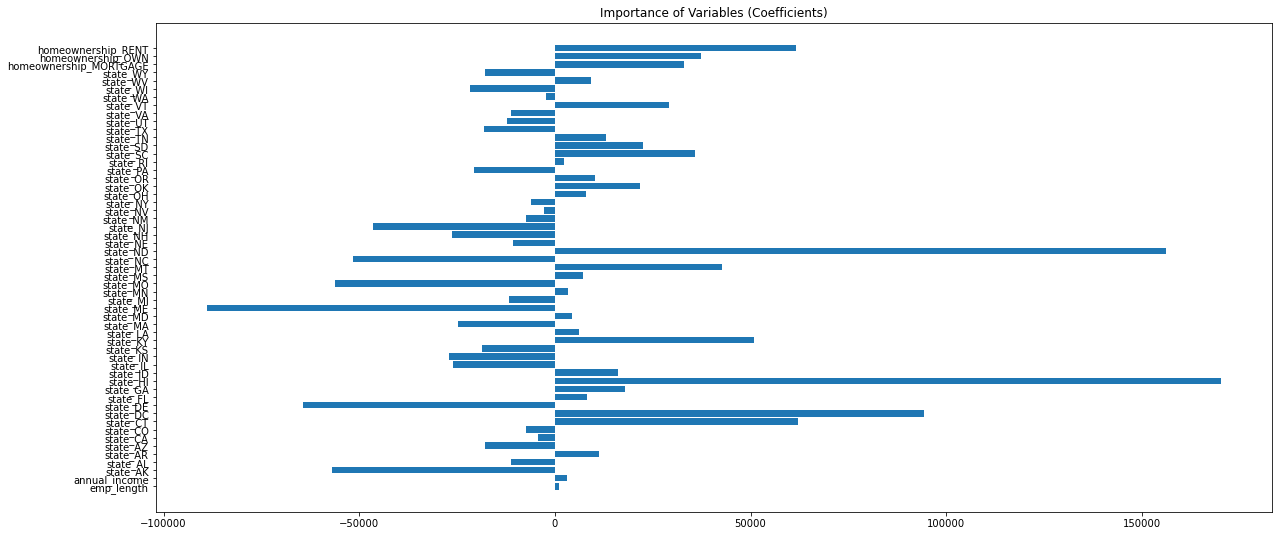

In [16]:
fig = plt.figure(figsize=(20,9))
plt.barh(x.columns, imp)
plt.title("Importance of Variables (Coefficients)")
plt.rc('axes', titlesize=100)
plt.show()

In [17]:
print("LR Score: {}".format(LR.score(x_train, y_train)))

LR Score: 0.02244306443194577


Unfortunately, this score is quite poor. Hopefully the KNN algorithm implemented will score better.

### KNN (K Nearest Neighbor) Regression

In [18]:
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(algorithm='auto', metric_params=None, n_neighbors=15, p=2, weights='uniform') 

model.fit(x_train, y_train)

y_pred_KNN = model.predict(x)

In [19]:
pred_KNN = scaled_x.copy()
pred_KNN['pred_interest_rate'] = y_pred_KNN
pred_KNN.head()

,emp_length,annual_income,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,homeownership_MORTGAGE,homeownership_OWN,homeownership_RENT,pred_interest_rate
0,0.000033,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000011,0.0,0.000000,10.770000
1,0.000250,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000025,12.326000
2,0.000075,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000025,0.0,0.0,0.000000,0.0,0.000025,15.042000
3,0.000033,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000033,11.151333
4,0.000286,1.0,0.0,0.0,0.0,0.0,0.000029,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000029,11.863333


In [20]:
print("KNN Score: {}".format(model.score(x_train,y_train)))

KNN Score: 0.08289239838049689


While better than the LR score, this score is quite poor. 

## Conclusion

While the data set was very interesting, the models generated were unfortunately quite poor. The predictions were not very accurate. Perhaps this is due to my assumption that the variables I chose did not have a large enough correlation to the actual `interest_rate`. With more time, I would look for new trends in the data and work on a better regression model. 